In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import numpy as np
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd
from dtw import *
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from netuno import SSTHelper, SubserieDTW
from sklearn.multioutput import MultiOutputRegressor

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
f_inv = lambda x: x + 180
f = lambda x: ((x+180) % 360) - 180

In [4]:
fp = '../dados/sst.mnmean.nc'
ds = SSTHelper.load_dataset(fp)
df = SSTHelper.load_dataframe(ds)

In [13]:
df['lat'] -= 0.5
df['lon'] -= 0.5

## Obtendo 5 pontos no mar
* Um ponto na região do ENSO;
 -> lat = 20°, lon = -132° (https://www.google.com.br/maps/place/20%C2%B000'00.0%22N+132%C2%B000'00.0%22W/@22.1775213,-151.1364928,3.87z/data=!4m4!3m3!8m2!3d20!4d-132?entry=ttu)

* Um ponto na costa do Chile (Corrente de Humboldt);
 -> lat = -22°, lon = -72° (https://www.google.com.br/maps/place/22%C2%B000'00.0%22S+72%C2%B000'00.0%22W/@-21.7898533,-87.474343,4.04z/data=!4m4!3m3!8m2!3d-22!4d-72?entry=ttu)

* Um ponto no meio do Mediterrâneo;
 -> lat = 36°, lon = 18° (https://www.google.com.br/maps/place/36%C2%B000'00.0%22N+18%C2%B000'00.0%22E/@36.0000043,17.9974251,17z/data=!3m1!4b1!4m4!3m3!8m2!3d36!4d18?entry=ttu)

* Um ponto no meio do Atlântico;
 -> lat = 0°, lon = -22° (https://www.google.com.br/maps/place/0%C2%B000'00.0%22N+22%C2%B000'00.0%22W/@-11.0144452,-50.6148726,3z/data=!4m3!3m2!8m1!4d-22?entry=ttu)

* Um ponto no extremo Índico (ponto de maior latitude, temperaturas mais baixas)
 -> lat = -56°, lon = 80° (https://www.google.com.br/maps/place/56%C2%B000'00.0%22S+80%C2%B000'00.0%22E/@-36.027701,54.6888129,3z/data=!4m4!3m3!8m2!3d-56!4d80?entry=ttu)

In [14]:
split_date = '2021-12-01'

chil = SubserieDTW(df, -22, -72, split_date, forecast_horizon=12)
medi = SubserieDTW(df, 36, 18, split_date, forecast_horizon=12)
atla = SubserieDTW(df, 0, -2, split_date, forecast_horizon=12)
enso = SubserieDTW(df, 20, -132, split_date, forecast_horizon=12)

indi = SubserieDTW(df, -56, 80, split_date, forecast_horizon=12)

### DS (Dynamic time warping + Support vector regression)
Implementando a técnica de forecasting apresentada pelo artigo [Improved Particle Swarm Optimization for Sea Surface Temperature Prediction](https://www.mdpi.com/1996-1073/13/6/1369) nomeada DS. Nesse algoritmo, para prever as próximas $x$ observações pegamos a janela referente as últimas observações que possuímos e procuramos subséries anteriores de mesmo tamanho utilizando DTW. Então, utilizamos as subséries mais próximas e as respectivas próximas $x$ observações encontradas para treinar um SVR.

### Queremos predizer a série em '?'
![img1](../resources/img1.png)
### Pegamos a janela mais próxima de tamanho $n$ e comparamos com a série em azul
![img2](../resources/img2.png)
### Pegamos as subséries mais próximas (x) e as observações seguintes (y)
![img3](../resources/img3.png)
### Treinamos um modelo regressor (SVR) para predizer os próximos valores utilizando x,y
![img4](../resources/img4.png)

In [42]:
from netuno import DSPipeline

In [43]:
df

,lat,lon,time,nbnds,sst,time_bnds
0,89.0,0.0,1981-12-01,0,-1.79,1981-12-01
2,89.0,0.0,1982-01-01,0,-1.79,1982-01-01
4,89.0,0.0,1982-02-01,0,-1.79,1982-02-01
6,89.0,0.0,1982-03-01,0,-1.79,1982-03-01
8,89.0,0.0,1982-04-01,0,-1.79,1982-04-01
...,...,...,...,...,...,...
64022390,-90.0,-1.0,2022-09-01,0,-1.79,2022-09-01
64022392,-90.0,-1.0,2022-10-01,0,-1.79,2022-10-01
64022394,-90.0,-1.0,2022-11-01,0,-1.79,2022-11-01
64022396,-90.0,-1.0,2022-12-01,0,-1.79,2022-12-01


### Indian Ocean

RMSE:  0.3462803012617692
MAPE:  0.628788659027029


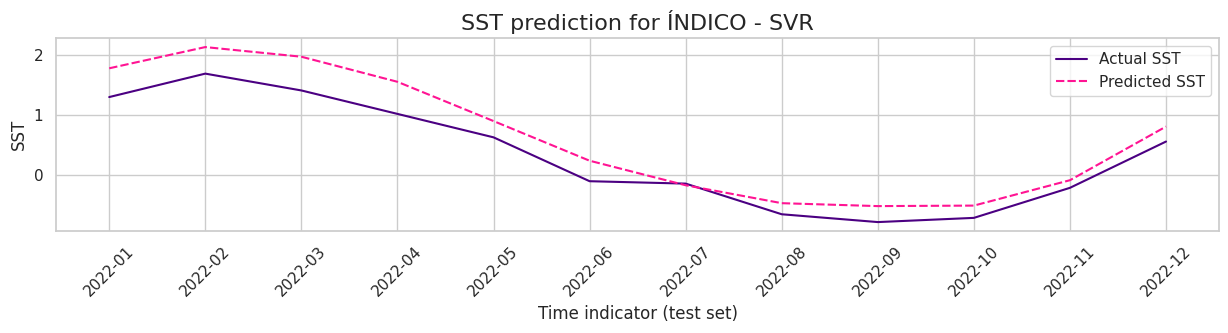

In [48]:
indi_pipeline = DSPipeline(df, -56, 80, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(series_sample_ratio=1, top_subseries_ratio=0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())
indi_pipeline.plot_predict('ÍNDICO - SVR', 'SVR')

### ENSO

[[22.76     22.6      22.609999 ... 23.49     23.66     23.65    ]
 [22.6      22.609999 22.57     ... 23.66     23.65     23.039999]
 [22.609999 22.57     22.55     ... 23.65     23.039999 21.96    ]
 ...
 [23.82     24.869999 25.35     ... 23.43     22.949999 23.26    ]
 [24.869999 25.35     25.359999 ... 22.949999 23.26     24.08    ]
 [25.35     25.359999 24.14     ... 23.26     24.08     24.269999]]
RMSE:  0.6916603413867086
MAPE:  0.023000001873888207


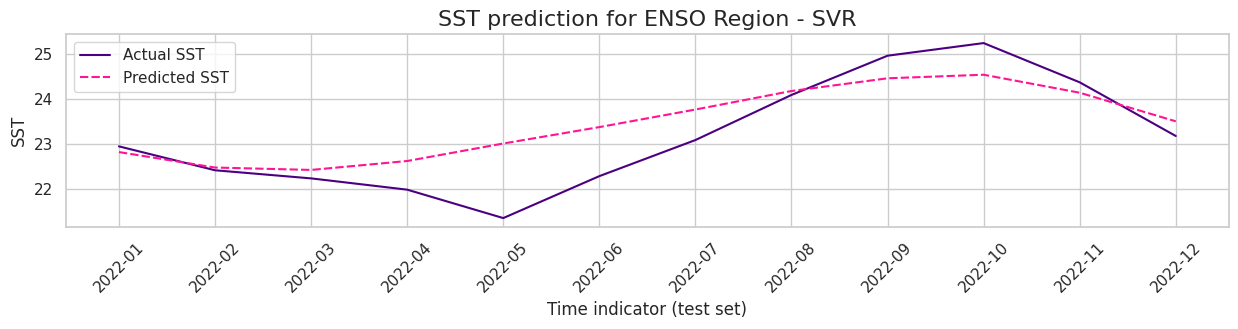

In [25]:
indi_pipeline = DSPipeline(df, 20, -132, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())

indi_pipeline.plot_predict('ENSO Region - SVR', 'SVR')

### Mediterranean

           lat  lon       time  nbnds   sst  time_bnds
0         89.0  0.0 1981-12-01      0 -1.79 1981-12-01
2         89.0  0.0 1982-01-01      0 -1.79 1982-01-01
4         89.0  0.0 1982-02-01      0 -1.79 1982-02-01
6         89.0  0.0 1982-03-01      0 -1.79 1982-03-01
8         89.0  0.0 1982-04-01      0 -1.79 1982-04-01
...        ...  ...        ...    ...   ...        ...
64022390 -90.0 -1.0 2022-09-01      0 -1.79 2022-09-01
64022392 -90.0 -1.0 2022-10-01      0 -1.79 2022-10-01
64022394 -90.0 -1.0 2022-11-01      0 -1.79 2022-11-01
64022396 -90.0 -1.0 2022-12-01      0 -1.79 2022-12-01
64022398 -90.0 -1.0 2023-01-01      0 -1.79 2023-01-01

[32011200 rows x 6 columns]
Initializing
Lat: 36, Lon: 18
[16.609999  15.66      14.83      14.83      16.16      18.57
 23.17      25.56      26.47      25.71      23.89      20.43
 17.71      16.        14.96      14.839999  15.92      19.23
 21.56      24.96      26.099998  24.64      22.5       19.92
 17.09      15.62      14.889999 

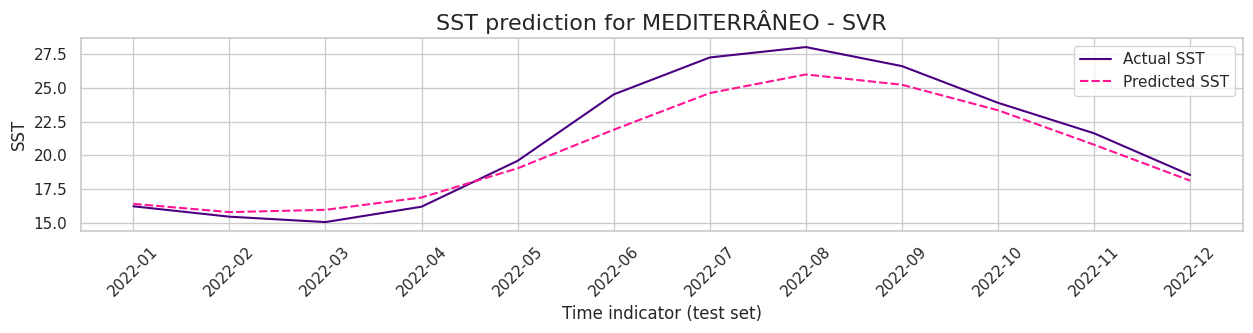

In [23]:
indi_pipeline = DSPipeline(df, 36, 18, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())
indi_pipeline.plot_predict('MEDITERRÂNEO - SVR', 'SVR')

### Atlantic Ocean

RMSE:  0.5347251466778309
MAPE:  0.015623326656531758


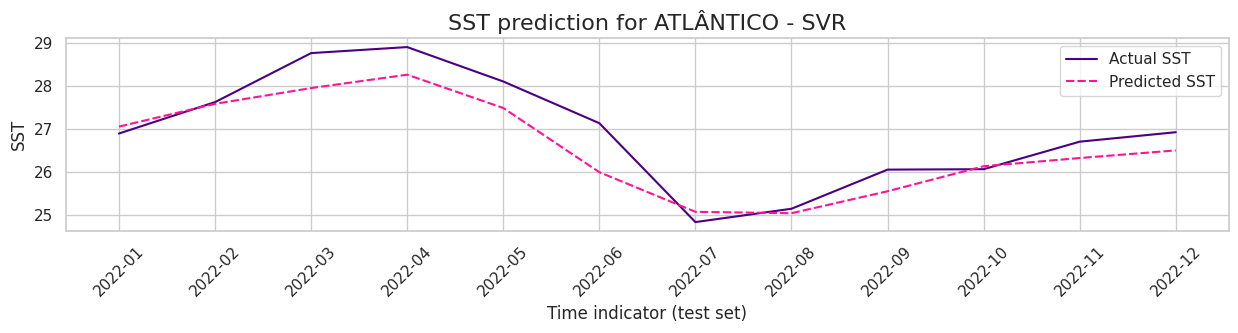

In [49]:
indi_pipeline = DSPipeline(df, 0, -22, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())
indi_pipeline.plot_predict('ATLÂNTICO - SVR', 'SVR')

### Humboldt

Initializing
Lat: -22, Lon: -72
[0.63670594 0.62641585 0.73441344 ... 0.32512861 0.33221498 0.35176736]
[ 0.27341187  0.2528317   0.4688269  ... -0.34974277 -0.33557004
 -0.29646528]
Total length: 2038
1920 22
Train/test proportion: 0.9421000981354269/0.010794896957801767


100%|██████████| 1728/1728 [00:02<00:00, 594.46it/s]


Obtained 1728 subseries
RMSE:  0.5206175016250814
MAPE:  0.02494474973382749


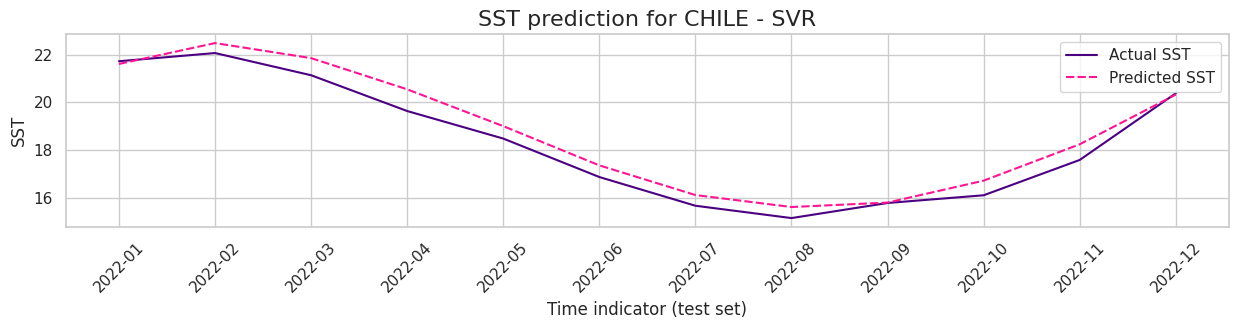

In [ ]:
indi_pipeline = DSPipeline(df, -22, -72, split_date, forecast_horizon=12)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())
indi_pipeline.plot_predict('CHILE - SVR', 'SVR')

In [ ]:
pipeline1 = DSPipeline(df, -56, 80, split_date, forecast_horizon=12)
print("RMSE: ", pipeline1.make_pipeline(1.0, 0.01))

pipeline2 = DSPipeline(df, 36, 18, split_date, forecast_horizon=12)
print("RMSE: ", pipeline2.make_pipeline(1.0, 0.01))

pipeline3 = DSPipeline(df, 0, -2, split_date, forecast_horizon=12)
print("RMSE: ", pipeline3.make_pipeline(1.0, 0.01))


Initializing
Lat: -56, Lon: 80
[0.67455363 0.79580027 0.80168074 ... 0.36432543 0.30134213 0.32530108]
[ 0.34910727  0.59160054  0.6033615  ... -0.27134913 -0.39731574
 -0.34939784]
Total length: 2038
1921 21
Train/test proportion: 0.9425907752698724/0.010304219823356232


  0%|          | 0/1729 [00:00<?, ?it/s]100%|██████████| 1729/1729 [00:04<00:00, 369.58it/s]


Obtained 1729 subseries
RMSE:  0.2374193772612375
Initializing
Lat: 36, Lon: 18
[0.22251053 0.19118312 0.1807629  ... 0.8891512  0.8264598  0.74953777]
[-0.55497897 -0.61763376 -0.6384742  ...  0.77830243  0.65291965
  0.49907553]
Total length: 2038
1921 21
Train/test proportion: 0.9425907752698724/0.010304219823356232


100%|██████████| 1729/1729 [00:04<00:00, 398.99it/s]


Obtained 1729 subseries
RMSE:  1.3170178034657616
Initializing
Lat: 0, Lon: -2
[0.52938354 0.5255629  0.75756633 ... 0.40840217 0.48857298 0.575799  ]
[ 0.05876708  0.05112576  0.51513267 ... -0.18319565 -0.02285403
  0.15159798]
Total length: 2038
1921 21
Train/test proportion: 0.9425907752698724/0.010304219823356232


100%|██████████| 1729/1729 [00:04<00:00, 374.05it/s]

Obtained 1729 subseries
RMSE:  0.38402854640960427


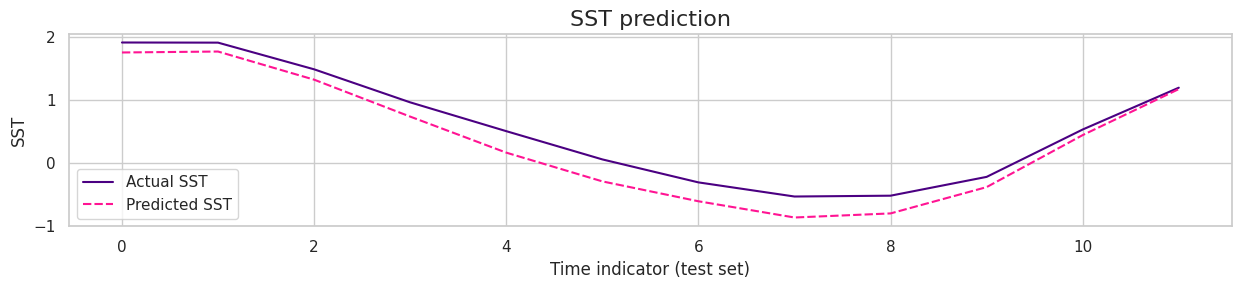

In [ ]:
pipeline1.plot_predict()

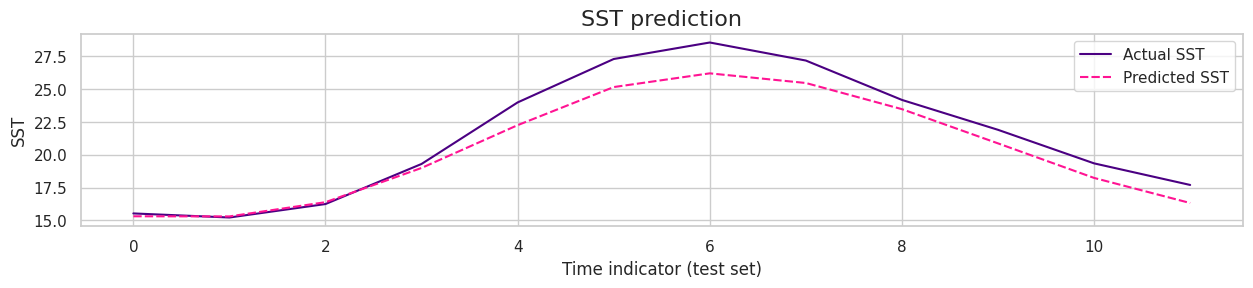

In [ ]:
pipeline2.plot_predict()

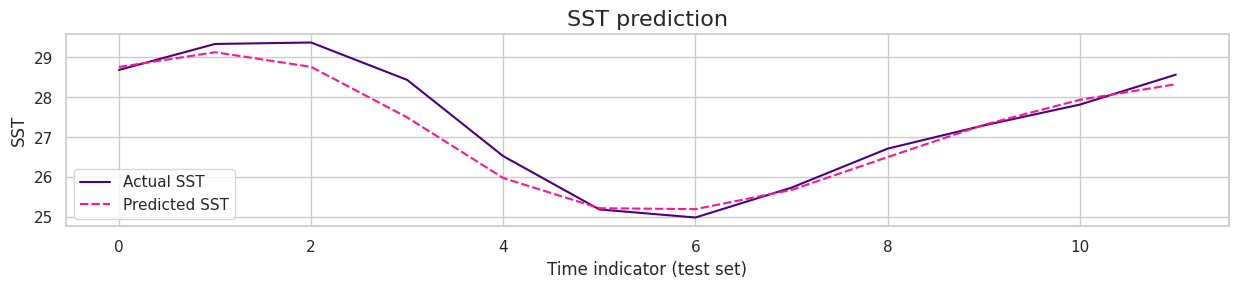

In [ ]:
pipeline3.plot_predict()

## Teste Expandido
Nessa seçao iremos expandir a quantidade de testes, executando o SARIMA para cerca de 100 séries temporais

#### Lendo os pontos pré-definidos

In [26]:
def read_list_points(filename):
    list_points = []
    with open(filename, 'r') as file:
        for line in file:
            line_split = line.split(',')
            try:
                list_points.append((int(line_split[1]), int(line_split[2])))
            except ValueError:
                pass
    return list_points

In [27]:
list_points = read_list_points('../dados/pontos.csv')

#### Rodando o SVR e calculando o erro

In [50]:
from netuno import DSPipeline

In [53]:
error_list = []

for point_coordinates in tqdm(list_points):
    try:
        point_pipeline = DSPipeline(df, point_coordinates[0], point_coordinates[1], split_date, forecast_horizon=12)
        rmse = point_pipeline.make_pipeline(.3, 0.3)
        mape = point_pipeline.evaluate_mape()
        error_list.append((rmse, mape))
    except:
        print(f'lat: {point_coordinates[0]}; lon:{point_coordinates[1]}')


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


In [54]:
results_df = pd.DataFrame(error_list)
results_df.rename({0: 'rmse', 1: 'mape'}, axis=1).to_csv('../dados/svr_results.csv')   

## Sequential SVR

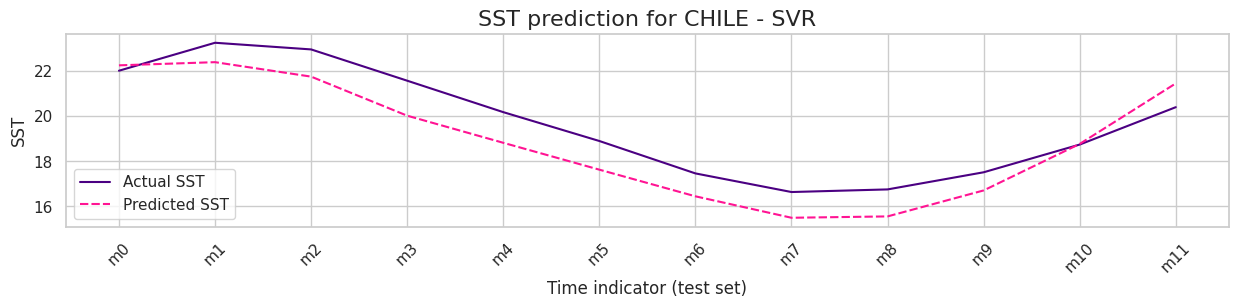

In [151]:
horizon = 12
indi_pipeline = DSPipeline(df, -22, -72, split_date, forecast_horizon=1)
indi_pipeline.make_pipeline(.3, 1.0)
_, y_true = indi_pipeline.subserie_dtw.get_test(horizon)
x_test = indi_pipeline.x_test[0].reshape(1, -1)

for i in range(horizon):
    y_pred = indi_pipeline.predict(x_test.reshape(1, -1))
    x_test = np.append(x_test, y_pred[0])
    x_test = x_test[1:]

y_pred = x_test[-horizon:]
SSTHelper.default_plot(y_pred, y_true, 'CHILE - SVR', 'SVR')


RMSE:  0.872083234522691
MAPE:  0.043373064102203956


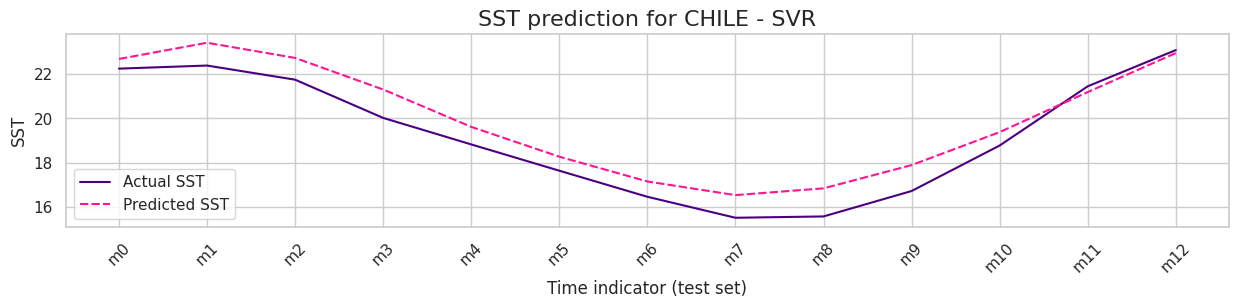

In [93]:
indi_pipeline = DSPipeline(df, -22, -72, split_date, forecast_horizon=13)
print("RMSE: ", indi_pipeline.make_pipeline(1.0, 0.3))
print("MAPE: ", indi_pipeline.evaluate_mape())
indi_pipeline.plot_predict('CHILE - SVR', 'SVR')

In [101]:
(indi_pipeline.x_test)

array([[23.92    , 22.91    , 22.01    , 20.38    , 19.93    , 18.539999,
        16.76    , 15.83    , 16.5     , 17.779999, 19.14    , 19.859999,
        21.81    , 23.84    , 23.42    , 22.65    , 21.02    , 18.97    ,
        17.609999, 16.96    , 17.49    , 18.31    , 19.64    , 21.07    ,
        22.85    , 24.269999, 24.33    , 20.9     , 19.859999, 18.69    ,
        17.23    , 17.18    , 17.23    , 18.3     , 20.289999, 22.51    ,
        24.5     , 25.119999, 23.58    , 21.47    , 19.949999, 18.46    ,
        17.21    , 16.22    , 16.199999, 16.72    , 17.779999, 20.39    ,
        22.41    , 23.63    , 22.31    , 21.08    , 19.82    , 17.67    ,
        16.48    , 15.809999, 16.75    , 17.359999, 19.22    , 21.199999,
        22.6     , 23.81    , 22.67    , 21.59    , 19.48    , 17.44    ,
        16.32    , 16.38    , 16.01    , 17.289999, 19.359999, 21.82    ,
        23.789999, 24.35    , 23.609999, 22.05    , 19.66    , 18.6     ,
        17.1     , 16.64    , 16.43   